# Alpha SecureReqNet Complete Example
This is an example of how Alpha SecureReqNet is trained from unprocessed data to evaluation.

In [ ]:
#danaderp May6'19
#Prediction For Main Issues Data Set

In [ ]:
import csv
from tensorflow.keras.preprocessing import text
from nltk.corpus import gutenberg
from string import punctuation
from tensorflow.keras.preprocessing.sequence import skipgrams

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

In [ ]:
from nltk.stem.snowball import SnowballStemmer
englishStemmer=SnowballStemmer("english")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dot, Input, Dense, Reshape, LSTM, Conv2D, Flatten, MaxPooling1D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Embedding, Multiply, Subtract
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# visualize model structure
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE

In [ ]:
from utils.read_data import Dynamic_Dataset,Processing_Dataset
from utils.vectorize_sentence import Embeddings

In [ ]:
#../data replaces datasets for the to access data
path = "../data/augmented_dataset/"
process_unit = Processing_Dataset(path)
ground_truth = process_unit.get_ground_truth()

In [ ]:
dataset = Dynamic_Dataset(ground_truth, path,False) # I'm not sure this needs to be False. RC

In [ ]:
#As the data is stored in a zip file isZip = True
test, train = process_unit.get_test_and_training(ground_truth,isZip = True)

In [ ]:
print(len(test))
print(len(train))
print(test[0])
print(train[0])

11612
104510
('(1,0)', b'Strip style attributes from HTML tags in add-on description\n\n\nThe old addons-server code stripped all HTML tag attributes (with some exceptions). This would strip out any style attributes. Even though we\'re using a dom-purify on addons-frontend, it doesn\'t strip style attributes. I don\'t know how serious it is because I can\'t think of a real XSS. However, there may be a possibility by crafting an add-on that has something like this in the description:\n<b style="background-image: url(javascript:alert(document.cookie))">placeholder</b>')
('(1,0)', b'The currently used Rails version, in the stable branch, is insecure\n\nYou should update the Gemfile.lock to hotfix this.\n\nhttp://weblog.rubyonrails.org/2014/2/18/Rails_3_2_17_4_0_3_and_4_1_0_beta2_have_been_released/')


In [ ]:
#Train/Test split verification
#for elem in test:
#    print(elem[0])

In [ ]:
#Added due to a lookup error in the next cell
#Adds nltk folder to the repository and is needed if the user doesn't have them already
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/roger/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Preprocesing Corpora
embeddings = Embeddings()
max_words = 5000 #<------- [Parameter]
pre_corpora_train = [doc for doc in train if len(doc[1])< max_words]
pre_corpora_test = [doc for doc in test if len(doc[1])< max_words]

In [ ]:
print(len(pre_corpora_train))
print(len(pre_corpora_test))

103863
11545


In [ ]:
embed_path = '../data/word_embeddings-embed_size_100-epochs_100.csv'
embeddings_dict = embeddings.get_embeddings_dict(embed_path)

In [ ]:
# .decode("utf-8") takes the doc's which are saved as byte files and converts them into strings for tokenization
corpora_train = [embeddings.vectorize(doc[1].decode("utf-8"), embeddings_dict) for doc in pre_corpora_train]#vectorization Inputs
corpora_test = [embeddings.vectorize(doc[1].decode("utf-8"), embeddings_dict) for doc in pre_corpora_test]#vectorization

In [ ]:
target_train = [[int(list(doc[0])[1]),int(list(doc[0])[3])] for doc in pre_corpora_train]#vectorization Output
target_test = [[int(list(doc[0])[1]),int(list(doc[0])[3])]for doc in pre_corpora_test]#vectorization Output
#target_train

In [ ]:
max_len_sentences_train = max([len(doc) for doc in corpora_train]) #<------- [Parameter]
max_len_sentences_test = max([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [ ]:
max_len_sentences = max(max_len_sentences_train,max_len_sentences_test)
print("Max. Sentence # words:",max_len_sentences)

Max. Sentence # words: 618


In [ ]:
min_len_sentences_train = min([len(doc) for doc in corpora_train]) #<------- [Parameter]
min_len_sentences_test = min([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [ ]:
min_len_sentences = max(min_len_sentences_train,min_len_sentences_test)
print("Mix. Sentence # words:",min_len_sentences)

Mix. Sentence # words: 1


In [ ]:
embed_size = np.size(corpora_train[0][0])

In [ ]:
#BaseLine Architecture <-------
embeddigs_cols = embed_size
input_sh = (max_len_sentences,embeddigs_cols,1)
#Selecting filters? 
#https://stackoverflow.com/questions/48243360/how-to-determine-the-filter-parameter-in-the-keras-conv2d-function
#https://stats.stackexchange.com/questions/196646/what-is-the-significance-of-the-number-of-convolution-filters-in-a-convolutional

N_filters = 128 # <-------- [HyperParameter] Powers of 2 Numer of Features
K = 2 # <-------- [HyperParameter] Number of Classess

In [ ]:
input_sh

(618, 100, 1)

In [ ]:
#baseline_model = Sequential()
gram_input = Input(shape = input_sh)

In [ ]:
# 1st Convolutional Layer Convolutional Layer (7-gram)
conv_1_layer = Conv2D(filters=32, input_shape=input_sh, activation='relu', 
                      kernel_size=(7,embeddigs_cols), padding='valid')(gram_input)
conv_1_layer.shape

TensorShape([None, 612, 1, 32])

In [ ]:
# Max Pooling 
max_1_pooling = MaxPooling2D(pool_size=((max_len_sentences-7+1),1), strides=None, padding='valid')(conv_1_layer)
max_1_pooling.shape

TensorShape([None, 1, 1, 32])

In [ ]:
# Fully Connected layer
fully_connected_1_gram = Flatten()(max_1_pooling)
fully_connected_1_gram.shape

TensorShape([None, 32])

In [ ]:
fully_connected_1_gram = Reshape((32, 1, 1))(fully_connected_1_gram)
fully_connected_1_gram.shape

TensorShape([None, 32, 1, 1])

In [ ]:
# 2nd Convolutional Layer (5-gram)
conv_2_layer = Conv2D(filters=64, kernel_size=(5,1), activation='relu', 
                      padding='valid')(fully_connected_1_gram)
conv_2_layer.shape

TensorShape([None, 28, 1, 64])

In [ ]:
max_2_pooling = MaxPooling2D(pool_size=((32-5+1),1), strides=None, padding='valid')(conv_2_layer)
max_2_pooling.shape

TensorShape([None, 1, 1, 64])

In [ ]:
# Fully Connected layer
fully_connected_2_gram = Flatten()(max_2_pooling)
fully_connected_2_gram.shape

TensorShape([None, 64])

In [ ]:
fully_connected_2_gram = Reshape((64, 1, 1))(fully_connected_2_gram)
fully_connected_2_gram.shape

TensorShape([None, 64, 1, 1])

In [ ]:
# 3rd Convolutional Layer (3-gram)
conv_3_layer =  Conv2D(filters=128, kernel_size=(3,1), activation='relu', 
                      padding='valid')(fully_connected_2_gram)
conv_3_layer.shape

TensorShape([None, 62, 1, 128])

In [ ]:
# 4th Convolutional Layer (3-gram)
conv_4_layer = Conv2D(filters=128, kernel_size=(3,1), activation='relu', 
                     padding='valid')(conv_3_layer)
conv_4_layer.shape

TensorShape([None, 60, 1, 128])

In [ ]:
# 5th Convolutional Layer (3-gram)
conv_5_layer = Conv2D(filters=64, kernel_size=(3,1), activation='relu', 
                     padding='valid')(conv_4_layer)
conv_5_layer.shape

TensorShape([None, 58, 1, 64])

In [ ]:
# Max Pooling
max_5_pooling = MaxPooling2D(pool_size=(58,1), strides=None, padding='valid')(conv_5_layer)
max_5_pooling.shape

TensorShape([None, 1, 1, 64])

In [ ]:
# Fully Connected layer
fully_connected = Flatten()(max_5_pooling)
fully_connected.shape

TensorShape([None, 64])

In [ ]:
# 1st Fully Connected Layer
deep_dense_1_layer = Dense(32, activation='relu')(fully_connected)
deep_dense_1_layer = Dropout(0.2)(deep_dense_1_layer) # <-------- [HyperParameter]

In [ ]:
deep_dense_1_layer.shape

TensorShape([None, 32])

In [ ]:
# 2nd Fully Connected Layer
deep_dense_2_layer = Dense(32, activation='relu')(deep_dense_1_layer)
deep_dense_2_layer = Dropout(0.2)(deep_dense_2_layer) # <-------- [HyperParameter]

In [ ]:
deep_dense_2_layer.shape

TensorShape([None, 32])

In [ ]:
# 3rd Fully Connected Layer
deep_dense_3_layer = Dense(16, activation='relu')(deep_dense_2_layer)
deep_dense_3_layer = Dropout(0.2)(deep_dense_3_layer) # <-------- [HyperParameter]

In [ ]:
deep_dense_3_layer.shape

TensorShape([None, 16])

In [ ]:
predictions = Dense(K, activation='softmax')(deep_dense_3_layer)

In [ ]:
#Criticality Model
criticality_network = Model(inputs=[gram_input],outputs=[predictions]) 

In [ ]:
print(criticality_network.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 618, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 612, 1, 32)        22432     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 1, 1)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 1, 64)         384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)         

In [ ]:
#Seting up the Model
criticality_network.compile(optimizer='adam',loss='binary_crossentropy',
                                  metrics=['accuracy'])

In [ ]:
#Data set organization
from tempfile import mkdtemp
import os.path as path

In [ ]:
#Memoization 
file_corpora_train_x = path.join(mkdtemp(), 'alex-res-adapted-003_temp_corpora_train_x.dat') #Update per experiment
file_corpora_test_x = path.join(mkdtemp(), 'alex-res-adapted-003_temp_corpora_test_x.dat')

In [ ]:
#Shaping
shape_train_x = (len(corpora_train),max_len_sentences,embeddigs_cols,1)
shape_test_x = (len(corpora_test),max_len_sentences,embeddigs_cols,1)

In [ ]:
#Data sets
corpora_train_x = np.memmap(
        filename = file_corpora_train_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_train_x)

In [ ]:
corpora_test_x = np.memmap( #Test Corpora (for future evaluation)
        filename = file_corpora_test_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_test_x)

In [ ]:
target_train_y = np.array(target_train) #Train Target
target_test_y = np.array(target_test) #Test Target (for future evaluation)

In [ ]:
corpora_train_x.shape

(103863, 618, 100, 1)

In [ ]:
target_train_y.shape

(103863, 2)

In [ ]:
corpora_test_x.shape

(11545, 618, 100, 1)

In [ ]:
target_test_y.shape

(11545, 2)

In [ ]:
#Reshaping Train Inputs
for doc in range(len(corpora_train)):
    #print(corpora_train[doc].shape[1])
    for words_rows in range(corpora_train[doc].shape[0]):
        embed_flatten = np.array(corpora_train[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_train_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [ ]:
#Reshaping Test Inputs (for future evaluation)
for doc in range(len(corpora_test)):
    for words_rows in range(corpora_test[doc].shape[0]):
        embed_flatten = np.array(corpora_test[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_test_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [ ]:
#CheckPoints
#csv_logger = CSVLogger(system+'_training.log')
# filepath changed from: "alex-adapted-res-003/best_model.hdf5" for testing
# The folder alex-adapted-res-003 doesn't exist yet in the repository. RC created 08_test in the root folder 
# manually
filepath = "../08_test/best_model.hdf5"

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks_list = [es,mc]

In [ ]:
#Model Fitting
history = criticality_network.fit(
            x = corpora_train_x, 
            y = target_train_y,
            #batch_size=64,
            epochs=2000, #5 <------ Hyperparameter
            validation_split = 0.2,
            callbacks=callbacks_list
)

Epoch 1/3
2595/2597 [============================>.] - ETA: 0s - loss: 0.0833 - accuracy: 0.9712
Epoch 00001: val_accuracy improved from -inf to 0.99456, saving model to ../08_test/best_model.hdf5
2597/2597 [==============================] - 59s 23ms/step - loss: 0.0833 - accuracy: 0.9712 - val_loss: 0.0145 - val_accuracy: 0.9946
Epoch 2/3
2596/2597 [============================>.] - ETA: 0s - loss: 0.0789 - accuracy: 0.9724
Epoch 00002: val_accuracy improved from 0.99456 to 0.99788, saving model to ../08_test/best_model.hdf5
2597/2597 [==============================] - 60s 23ms/step - loss: 0.0789 - accuracy: 0.9724 - val_loss: 0.0056 - val_accuracy: 0.9979
Epoch 3/3
2595/2597 [============================>.] - ETA: 0s - loss: 0.0750 - accuracy: 0.9738
Epoch 00003: val_accuracy did not improve from 0.99788
2597/2597 [==============================] - 59s 23ms/step - loss: 0.0750 - accuracy: 0.9738 - val_loss: 0.0064 - val_accuracy: 0.9977


In [ ]:
# filepath changed from: 'alex-adapted-res-003/history_training.csv' for testing
#Saving Training History
df_history = pd.DataFrame.from_dict(history.history)
df_history.to_csv('../08_test/history_training.csv', encoding='utf-8',index=False)

In [ ]:
criticality_network.save(filepath)
df_history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.083302,0.971176,0.014487,0.994560
1,0.078915,0.972355,0.005639,0.997882
2,0.074980,0.973775,0.006398,0.997737


In [ ]:
# filepath changed from: 'alex-adapted-res-003/corpora_test_x.npy' &
# 'alex-adapted-res-003/corpora_test_x./target_test_y.npy' for testing
#Saving Test Data
np.save('../08_test/corpora_test_x.npy',corpora_test_x)
np.save('../08_test/target_test_y.npy',target_test_y)

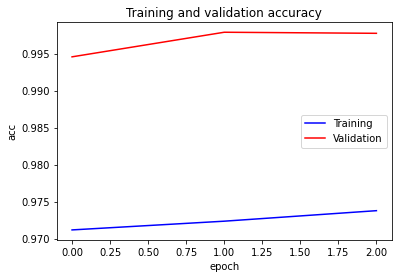

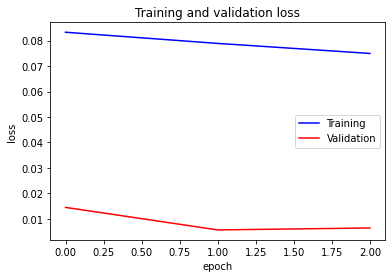

In [ ]:
#Evaluation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs2 = range(len(acc))
 
plt.plot(epochs2, acc, 'b', label='Training')
plt.plot(epochs2, val_acc, 'r', label='Validation')
plt.title('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
 
plt.figure()
 
plt.plot(epochs2, loss, 'b', label='Training')
plt.plot(epochs2, val_loss, 'r', label='Validation')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
 
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score,precision_recall_curve
#funcsigs replaces the (deprecated?) sklearn signature
from funcsigs import signature
#from sklearn.utils.fixes import signature
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# filepath changed from: 'alex-adapted-res-003/best_model.hdf5' for testing
path = '../08_test/best_model.hdf5'
criticality_network_load = load_model(path) #<----- The Model

In [ ]:
score = criticality_network_load.evaluate(corpora_test_x, target_test_y, verbose=1)

361/361 [==============================] - 2s 4ms/step - loss: 0.0922 - accuracy: 0.9668


In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.09222683310508728
Test accuracy: 0.9668254852294922


In [ ]:
history_predict = criticality_network_load.predict(x=corpora_test_x)
history_predict

array([[2.6430425e-01, 7.3569572e-01],
       [4.5163062e-04, 9.9954838e-01],
       [1.0000000e+00, 7.6218362e-15],
       ...,
       [3.3640151e-03, 9.9663597e-01],
       [1.0000000e+00, 4.5417864e-16],
       [9.8594353e-03, 9.9014050e-01]], dtype=float32)

In [ ]:
inferred_data = pd.DataFrame(history_predict,columns=list('AB'))
target_data = pd.DataFrame(target_test_y,columns=list('LN'))
data = target_data.join(inferred_data)

In [ ]:
y_true = list(data['L'])
y_score= list(data['A'])
average_precision = average_precision_score(y_true, y_score)

In [ ]:
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 1.00


In [ ]:
#ROC Curve (all our samples are balanced)
auc = roc_auc_score(y_true, y_score)
print('AUC: %.3f' % auc)

AUC: 0.994
